In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time
from IPython.display import clear_output

In [ ]:
# Khởi tạo mê cung (0 = đường đi, 1 = tường, 2 = đích)
maze = np.array([
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 1, 0, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 1, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
    [1, 1, 1, 0, 0, 1, 0, 0, 0, 2]
])

In [ ]:
# Vị trí ban đầu của agent
agent_pos = [0, 0]

# Các hướng di chuyển [lên, xuống, trái, phải]
actions = [[-1, 0], [1, 0], [0, -1], [0, 1]]

In [ ]:
# Q-learning
Q_table = np.zeros((maze.shape[0], maze.shape[1], 4))
alpha = 0.1
gamma = 0.9
epsilon = 0.1

In [ ]:
# Hàm chọn hành động
def choose_action(state):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, 4)
    else:
        return np.argmax(Q_table[state[0], state[1]])

In [ ]:
# Hàm kiểm tra nếu một vị trí là hợp lệ
def valid_move(pos):
    if 0 <= pos[0] < maze.shape[0] and 0 <= pos[1] < maze.shape[1]:
        return maze[pos[0], pos[1]] != 1
    return False

In [ ]:
# Hàm kiểm tra nếu agent bị kẹt (đường cụt)
def is_dead_end(pos):
    dead_end = True
    for action in actions:
        new_pos = [pos[0] + action[0], pos[1] + action[1]]
        if valid_move(new_pos):
            dead_end = False  # Nếu có ít nhất một hướng hợp lệ, không phải đường cụt
            break
    return dead_end

In [ ]:
#Tính phần thưởng
def get_reward(pos):
    if maze[pos[0], pos[1]] == 2:
        return 100  # Đạt đích
    elif is_dead_end(pos):
        return -10  # Đường cụt
    else:
        return -0.1  # Phần thưởng âm cho mỗi bước đi

In [ ]:
#Cập nhật Q-values
def update_q(state, action, reward, next_state):
    current_q = Q_table[state[0], state[1], action]
    max_next_q = np.max(Q_table[next_state[0], next_state[1]])
    new_q = (1 - alpha) * current_q + alpha * (reward + gamma * max_next_q)
    Q_table[state[0], state[1], action] = new_q

In [ ]:
# Vẽ mê cung và agent
def draw_maze(agent_pos):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(5, 5))

    # Vẽ lưới
    ax.set_xticks(np.arange(-.5, maze.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, maze.shape[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    # Vẽ tường và đích
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i, j] == 1:
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color='black'))
            elif maze[i, j] == 2:
                ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=True, color='green'))

    # Vẽ agent
    agent_circle = Circle((agent_pos[1], agent_pos[0]), 0.3, color='blue')
    ax.add_patch(agent_circle)

    # Ẩn trục x, y
    ax.axis('off')

    # Cài đặt giới hạn và hiển thị
    plt.xlim([-0.5, maze.shape[1] - 0.5])
    plt.ylim([maze.shape[0] - 0.5, -0.5])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [ ]:
import csv

# Hàm lưu kết quả sau mỗi epoch vào file CSV
def save_results_to_csv(epoch, total_reward, steps, filename='training_results.csv'):
    file_exists = False
    try:
        # Kiểm tra xem file đã tồn tại chưa
        with open(filename, 'r'):
            file_exists = True
    except FileNotFoundError:
        pass

    # Ghi dữ liệu vào file CSV (thêm dòng mới sau mỗi epoch)
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        # Nếu file mới được tạo, ghi tiêu đề
        if not file_exists:
            writer.writerow(["Epoch", "Total Reward"])
        # Ghi dữ liệu cho mỗi epoch
        writer.writerow([epoch + 1, total_reward])

In [ ]:
# Hàm demo quá trình di chuyển của agent với Q-table đã được huấn luyện
def demo_best_agent(Q_table, delay=0.1):
    agent_pos = [0, 0]  # Đặt lại vị trí ban đầu

    while maze[agent_pos[0], agent_pos[1]] != 2:  # Tiếp tục cho đến khi đến đích
        draw_maze(agent_pos)
        action = np.argmax(Q_table[agent_pos[0], agent_pos[1]])  # Chọn hành động tốt nhất từ Q-table
        new_pos = [agent_pos[0] + actions[action][0], agent_pos[1] + actions[action][1]]

        if valid_move(new_pos):
            agent_pos = new_pos
            time.sleep(delay)  # Thêm độ trễ để quan sát quá trình di chuyển

    draw_maze(agent_pos)  # Vẽ lần cuối khi đã đến đích
    print("Agent đã đến đích!")

In [ ]:
# Mô phỏng quá trình di chuyển của agent
def simulate_agent(epochs=2000, delay=0.0001, save_filename='training_results.csv'):
    global agent_pos
    rewards_per_epoch = []  # Danh sách để lưu tổng phần thưởng mỗi epoch
    step = 0

    for epoch in range(epochs):
        agent_pos = [0, 0]  # Đặt lại vị trí ban đầu
        total_reward = 0  # Khởi tạo tổng phần thưởng cho mỗi lần huấn luyện
        steps = 0  # Đếm số bước agent di chuyển trong mỗi epoch

        while maze[agent_pos[0], agent_pos[1]] != 2:
            action = choose_action(agent_pos)
            new_pos = [agent_pos[0] + actions[action][0], agent_pos[1] + actions[action][1]]

            if valid_move(new_pos):
                reward = get_reward(new_pos)
                update_q(agent_pos, action, reward, new_pos)
                agent_pos = new_pos
                total_reward += reward  # Cộng phần thưởng mỗi lần agent di chuyển
                steps += 1  # Tăng số bước
                draw_maze(agent_pos)  # Hiển thị mê cung và hành động của agent
                time.sleep(delay)  # Thêm độ trễ để xem chuyển động

        # Lưu tổng phần thưởng sau mỗi epoch
        rewards_per_epoch.append(total_reward)
        print(f'Epoch {epoch + 1}: Total Reward: {total_reward}, Steps: {steps}')

        # Lưu dữ liệu sau mỗi epoch vào file CSV
        save_results_to_csv(epoch, total_reward, steps, save_filename)

    # Vẽ đồ thị tổng phần thưởng theo từng epoch
    plt.figure(figsize=(10, 4))
    plt.plot(rewards_per_epoch, label="Total Reward per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Total Reward")
    plt.title("Training Progress - Total Reward per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Trả về kết quả huấn luyện
    return rewards_per_epoch

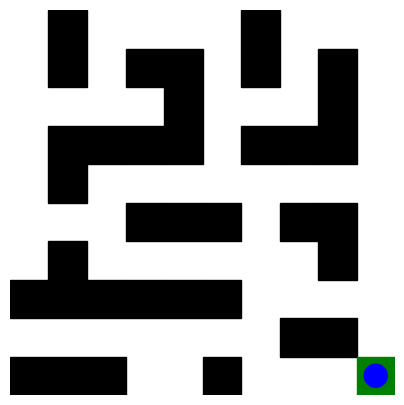

Epoch 2000: Total Reward: 97.9, Steps: 22


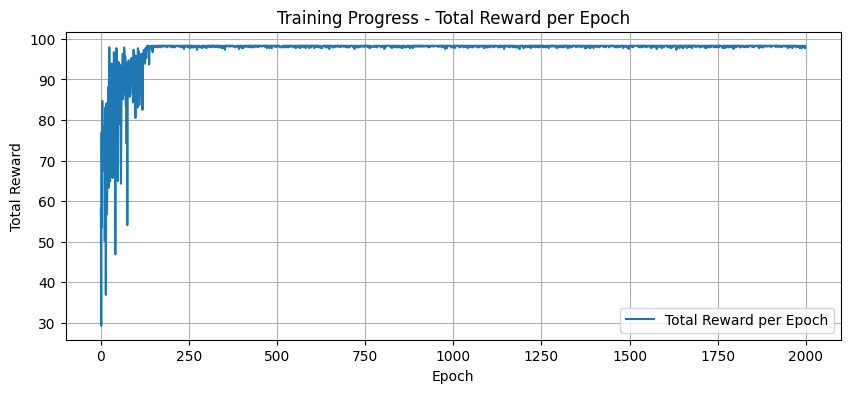

Training results: [58.29999999999968, 29.29999999999974, 76.89999999999995, 53.49999999999961, 84.70000000000005, 71.09999999999985, 67.4999999999998, 68.89999999999984, 77.69999999999996, 78.49999999999997, 76.49999999999994, 50.09999999999956, 64.69999999999976, 83.10000000000002, 36.89999999999937, 76.09999999999994, 84.10000000000004, 56.699999999999655, 61.29999999999972, 81.70000000000002, 80.1, 88.10000000000002, 63.29999999999975, 92.10000000000001, 97.9, 82.30000000000001, 64.89999999999978, 88.70000000000002, 89.30000000000003, 87.10000000000002, 83.10000000000002, 93.9, 72.69999999999987, 65.69999999999979, 69.09999999999982, 92.70000000000002, 85.70000000000003, 96.7, 84.10000000000004, 75.49999999999991, 85.50000000000003, 46.899999999999515, 88.50000000000003, 70.69999999999985, 97.7, 93.9, 85.90000000000003, 64.89999999999978, 85.30000000000004, 87.50000000000003, 94.30000000000001, 89.50000000000003, 92.70000000000002, 79.09999999999997, 93.7, 90.50000000000001, 74.2999

In [ ]:
training_results = simulate_agent()
print("Training results:", training_results)

In [1]:
# Chạy demo với Q-table tốt nhất đã huấn luyện
demo_best_agent(Q_table)

NameError: name 'demo_best_agent' is not defined